# Probability of Default (PD) Modeling - Logistic Regression

**Objective**:

- Load the cleaned dataset (`credit_risk_dataset_cleaned.csv`).
- Split into train/test sets.
- Train a **Logistic Regression** model to predict `loan_status` (0=non-default, 1=default).
- Evaluate performance (AUC, confusion matrix, recall for the bad class, etc.).

**IFRS 9 Context**:  
These predicted probabilities will serve as Probability of Default (PD). Eventually, I'll integrate them with LGD/EAD assumptions to compute ECL.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 30)

# Load the cleaned CSV
df = pd.read_csv("../data/credit_risk_dataset_cleaned.csv")

print('Shape of the cleaned dataset:', df.shape)
df.head()

Shape of the cleaned dataset: (29465, 13)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_to_income_ratio
0,22.0,59000.0,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,0.593210
1,21.0,9600.0,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,0.104156
2,25.0,9600.0,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,0.572857
3,23.0,65500.0,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,0.534343
4,24.0,54400.0,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,0.643371


**Data check:**
- Confirming that missing values are addressed and outlier capped (loan_int_rate, person_income, etc.).
- Next, I'll handle categorical columns for modeling

## Handling Categorical Variables

Since I'm using Logistic Regression, I need all features to be numeric. Columns like `person_home_ownership`, `loan_intent`, or `loan_grade` may still be `object` type. I'll apply **one-hot encoding** to convert them into dummy variables. I'll use `drop_first=True` to avoid perfect collinearity.

In [5]:
# Identify object columns
cat_cols = df.select_dtypes(include=['object']).columns
print(f'Categorical columns: {cat_cols.tolist()}')

# One-hot encode them
df_encoded = pd.get_dummies(df, columns = cat_cols, drop_first=True)

print(f'After encoding, shape: {df_encoded.shape}')
df_encoded.head()

Categorical columns: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
After encoding, shape: (29465, 24)


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,loan_to_income_ratio,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,22.0,59000.0,123.0,35000,16.02,1,0.59,3,0.593210,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True
1,21.0,9600.0,5.0,1000,11.14,0,0.10,2,0.104156,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False
2,25.0,9600.0,1.0,5500,12.87,1,0.57,3,0.572857,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False
3,23.0,65500.0,4.0,35000,15.23,1,0.53,2,0.534343,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False
4,24.0,54400.0,8.0,35000,14.27,1,0.55,4,0.643371,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True


**Encoding Result**:
- I now have a fully numeric DataFrame in `df_encoded`.
- Next, I'll define my feature matrix (X) and target vector (y), then split into train/test.

In [7]:
from sklearn.model_selection import train_test_split

target_col = 'loan_status'

# X = all columns except loan_status
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state=42,
    stratify=y # helps keep the same default ratio
)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')      

Features shape: (29465, 23)
Target shape: (29465,)
X_train shape: (23572, 23)
X_test shape: (5893, 23)
y_train shape: (23572,)
y_test shape: (5893,)


### Train a Logistic Regression Baseline

I will now train a **Logistic Regression** model to predict `loan_status` (0 = good loan, 1 = default). The predicted for class 1 will represent the **Probability of Default (PD)**.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score
)

# Initialize logistic regression
model_lr = LogisticRegression(max_iter=1000, random_state=42)

# Fit
model_lr.fit(X_train, y_train)

# Predict probabilities (PD for class=1)
y_prob = model_lr.predict_proba(X_test)[:,1]
y_pred = model_lr.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {acc:.3f}')
print(f'AUC: {auc:.3f}\n')
print('Classification Report:\n', report)
print('Confusion Matrix:\n', conf_mat)

Accuracy: 0.856
AUC: 0.857

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91      4600
           1       0.78      0.48      0.59      1293

    accuracy                           0.86      5893
   macro avg       0.83      0.72      0.75      5893
weighted avg       0.85      0.86      0.84      5893

Confusion Matrix:
 [[4428  172]
 [ 675  618]]


C:\Users\SebastianGM\anaconda3\envs\pd_model_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Logistic Regression Results:

**Metrics** (Test Set):
- **Accuracy**: 0.856
- **AUC**: 0.857

**Classification Report**:
- **Non-Default (class 0)**: Precision ~0.87, Recall ~0.96, very high accuracy in labeling good loans.
- **Default (class 1)**: Precision ~0.78, Recall ~0.48, meaning I catch around 48% of actual defaulters.

**Confusion Matrix**:
- [[4428, 172],
   [675, 618]]
- Of 1293 actual defaulters, 618 are correctly identified, 675 missed.

### Interpretation for Credit Risk

- Overall, the model ranks well (AUC 0.857), indicating decent separation between good and bad loans.
- However, **recall for bad loans** is only ~48%. In a credit risk context , missing ~52% of actual defaulters could be costly.
- I may consider:
  1. **Threshold Tuning**: Instead of defaulting at probability=0.5, I could lower the threshold to catch more defaulters.
  2. **Advanced Models**: e.g., XGBoost or LightGBM, which might improve recall.
  3. **Further Feature Engineering**: Possibly additional domain features or transformations to boost predictive power.

### Plot ROC Curve

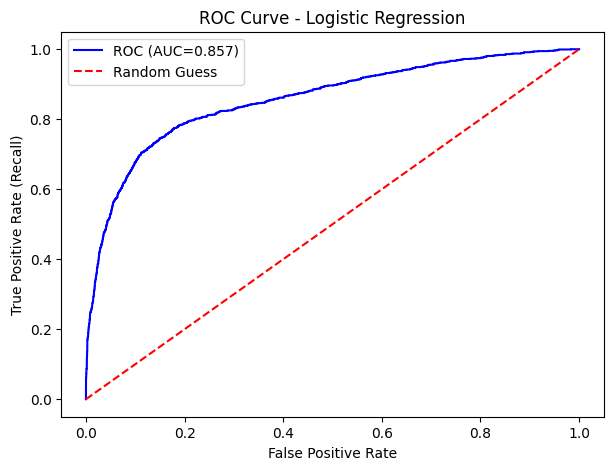

In [12]:
fpr, tpr, threshold = roc_curve(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='blue', label=f'ROC (AUC={auc:.3f})')
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Random Guess')
plt.title('ROC Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.show()

### Threshold Tuning for Recall vs Precision

By default, Logistic Regression uses a threshold of 0.5 for classifying loans as default (1) vs. non-default (0).
- If I lower that threshold, I'll catch more defaulters (higher recall) but label more good loans as bad (lower precision).
- If I raise it, I'll reduce false positives but likely miss more defaulters.

I'll explore threshold to see where I achieve a good balance.

In [18]:
thresholds = np.linspace(0, 1, 50)
precision_values = []
recall_values = []
f1_values = []

best_f1 = 0
best_thr = 0

# 3) Loop to fill arrays
for thr in thresholds:
    # y_prob is your continuous predictions from logistic regression
    y_pred_custom = (y_prob >= thr).astype(int)
    
    prec = precision_score(y_test, y_pred_custom, zero_division=0)
    rec = recall_score(y_test, y_pred_custom, zero_division=0)
    if prec + rec > 0:
        f1 = 2 * (prec * rec) / (prec + rec)
    else:
        f1 = 0

    precision_values.append(prec)
    recall_values.append(rec)
    f1_values.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print(f"Best F1: {best_f1:.3f} at threshold={best_thr:.2f}")

Best F1: 0.667 at threshold=0.33


### Plot Threshold vs Precision, Recall, F1

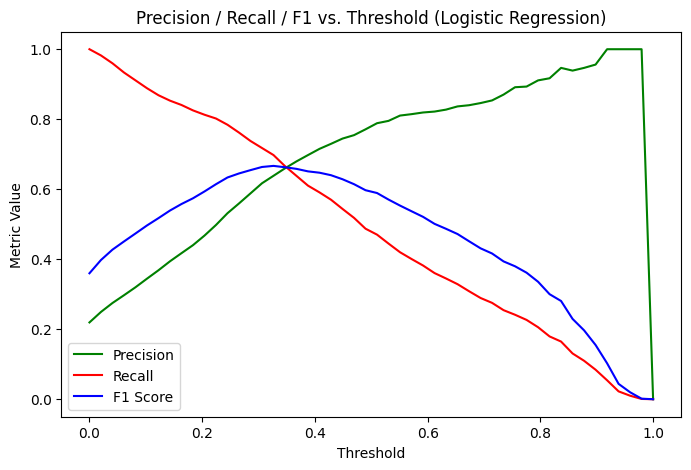

In [22]:
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision_values, label="Precision", color="green")
plt.plot(thresholds, recall_values, label="Recall", color="red")
plt.plot(thresholds, f1_values, label="F1 Score", color="blue")  # changed scolor->color
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Precision / Recall / F1 vs. Threshold (Logistic Regression)")
plt.legend()
plt.show()

### Precision / Recall / F1 vs. Threshold Vasualization

Below is the chart inllustrating how each metric varies with threshold for the Logistic Regression model.
- **Precision (green)** starts low at threshold=0 but rises as I increase the threshold, meaning fewer false positives at the cost of missing some defaulters.
- **Recall (red)** starts high at threshold=0 (everyhing predicted as default) and drops as threshold increases.
- **F1 (blue)** is highest at an intermediate threshold (~0.33), balancing precision and recall.

**Business Insight**
- If I choose a very low threshold, I'll catch nearly all defaulters but generate mani false positive
- If I choose a very high threshold, I'll reduce false positive but miss a large fraction of bad loans.
- The final threshold often depends on cost/benefits analysis or risk appetite in credit policy. 

## Additional Model: Decision Tree

A Simple Decision Tree can capture non-linear relationships.
- It can reduce overfitting by averaging multiple trees
- I'll compare its AUC and recall to Logistic Regression and the single Decision Tree

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_prob_rf = rf_model.predict_proba(X_test)[:,1]
y_pred_rf = rf_model.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)
report_rf = classification_report(y_test, y_pred_rf)
conf_mat_rf = confusion_matrix(y_test, y_pred_rf)

print(f'Random Forest Accuracy: {acc_rf:.3f}')
print(f'Random Forest AUC: {auc_rf:.3f}')
print(f'Classification Report:\n {report_rf}')
print(f'Confusion Matrix:\n {conf_mat_rf}')

Random Forest Accuracy: 0.931
Random Forest AUC: 0.936
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      4600
           1       0.95      0.72      0.82      1293

    accuracy                           0.93      5893
   macro avg       0.94      0.86      0.89      5893
weighted avg       0.93      0.93      0.93      5893

Confusion Matrix:
 [[4555   45]
 [ 359  934]]


### Random Forest Results

**Overall Perfroamnce**:
- **Accuracy**: 0.931
- **AUC**: 0.936

**Class 0 (Non-Default)**:
- Precision ~93%
- Recall ~99&
- F1 ~96%
Indicates the model rarely misclassifies good loans as bad.

**Class 1 (Default)**:
- Precision ~95%
- Recall ~72%
- F1 ~82%
Meaning it correctly flags about 72% of actual defaulters, a significant improvement over Logistic Regression. However, nearly 28% of bad loans are still missed.

**Confusion Matrix**:
\[
\begin{pmatrix}
4555 & 45 \\
359 & 934 \\
\end{pmatrix}

- Of 1293 actual defaulters, 934 are caught, and 359 are missed.
- The low false positive count (45) shows the model is also good at preserving non-defaulters.

**Interpretation**:
- The **AUC of 0.936** is quite high, suggesting strong ranking ability.
- The **72% recall for defaulters** is a notable improvement compared to baseline Logistic Regression (~48%), though some bad loans are still undetected.

**Next Steps**:
- Use **threshold tuning** for the Random Forest to further increase recall if missing defaulters is too costly.
- Compare with addition models.
